In [2]:
!pip install efficientnet_pytorch



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler


In [10]:
DATA_DIR = r"K:\plant villagee\PlantVillage"
OUTPUT_DIR = "checkpoints"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(OUTPUT_DIR, "efficientnet_b0_best.pth")

SEED = 42
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 12
LR = 3e-4
MIXUP_ALPHA = 0.2

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [11]:
def mixup(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


In [12]:
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(DATA_DIR, transform=train_tf)
val_dataset   = datasets.ImageFolder(DATA_DIR, transform=val_tf)

class_names = train_dataset.classes
num_classes = len(class_names)

labels = [y for _, y in train_dataset.samples]
class_counts = np.bincount(labels)
weights = 1.0 / (class_counts + 1e-6)
sample_weights = [weights[l] for l in labels]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Classes:", class_names)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Train samples: 20638
Val samples: 20638


In [13]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


Loaded pretrained weights for efficientnet-b0


In [14]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 4,026,763
Trainable parameters: 4,026,763


In [15]:
best_val_acc = 0
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

for epoch in range(1, NUM_EPOCHS + 1):

    model.train()
    total = 0
    correct = 0
    running_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")

    for X, y in pbar:
        X, y = X.to(DEVICE), y.to(DEVICE)

        # mixup
        X_mix, y_a, y_b, lam = mixup(X, y, MIXUP_ALPHA)

        optimizer.zero_grad()
        logits = model(X_mix)

        loss = lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        correct += (
            lam * (preds == y_a) + (1 - lam) * (preds == y_b)
        ).sum().item()

        total += X.size(0)
        running_loss += loss.item() * X.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---------------- VALIDATION ----------------
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)

            logits = model(X)
            loss = criterion(logits, y)

            preds = logits.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total += X.size(0)
            val_loss += loss.item() * X.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}: Train={train_acc:.4f} | Val={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model": model.state_dict(), "classes": class_names}, MODEL_PATH)
        print("✓ Saved best model")

print("\nTraining COMPLETE — Best Val Accuracy =", best_val_acc)


Epoch 1/12: 100%|██████████| 645/645 [07:40<00:00,  1.40it/s]


Epoch 1: Train=0.7751 | Val=0.9738
✓ Saved best model


Epoch 2/12: 100%|██████████| 645/645 [08:07<00:00,  1.32it/s]


Epoch 2: Train=0.8442 | Val=0.9884
✓ Saved best model


Epoch 3/12: 100%|██████████| 645/645 [07:52<00:00,  1.37it/s]


Epoch 3: Train=0.8597 | Val=0.9933
✓ Saved best model


Epoch 4/12: 100%|██████████| 645/645 [07:38<00:00,  1.41it/s]


Epoch 4: Train=0.8620 | Val=0.9909


Epoch 5/12: 100%|██████████| 645/645 [07:39<00:00,  1.40it/s]


Epoch 5: Train=0.8738 | Val=0.9946
✓ Saved best model


Epoch 6/12: 100%|██████████| 645/645 [07:21<00:00,  1.46it/s]


Epoch 6: Train=0.8823 | Val=0.9972
✓ Saved best model


Epoch 7/12: 100%|██████████| 645/645 [07:20<00:00,  1.46it/s]


Epoch 7: Train=0.8844 | Val=0.9950


Epoch 8/12: 100%|██████████| 645/645 [07:17<00:00,  1.47it/s]


Epoch 8: Train=0.8722 | Val=0.9957


Epoch 9/12: 100%|██████████| 645/645 [07:15<00:00,  1.48it/s]


Epoch 9: Train=0.8942 | Val=0.9977
✓ Saved best model


Epoch 10/12: 100%|██████████| 645/645 [07:20<00:00,  1.47it/s]


Epoch 10: Train=0.8896 | Val=0.9984
✓ Saved best model


Epoch 11/12: 100%|██████████| 645/645 [07:21<00:00,  1.46it/s]


Epoch 11: Train=0.8771 | Val=0.9983


Epoch 12/12: 100%|██████████| 645/645 [07:19<00:00,  1.47it/s]


Epoch 12: Train=0.8892 | Val=0.9988
✓ Saved best model

Training COMPLETE — Best Val Accuracy = 0.9987886423103014


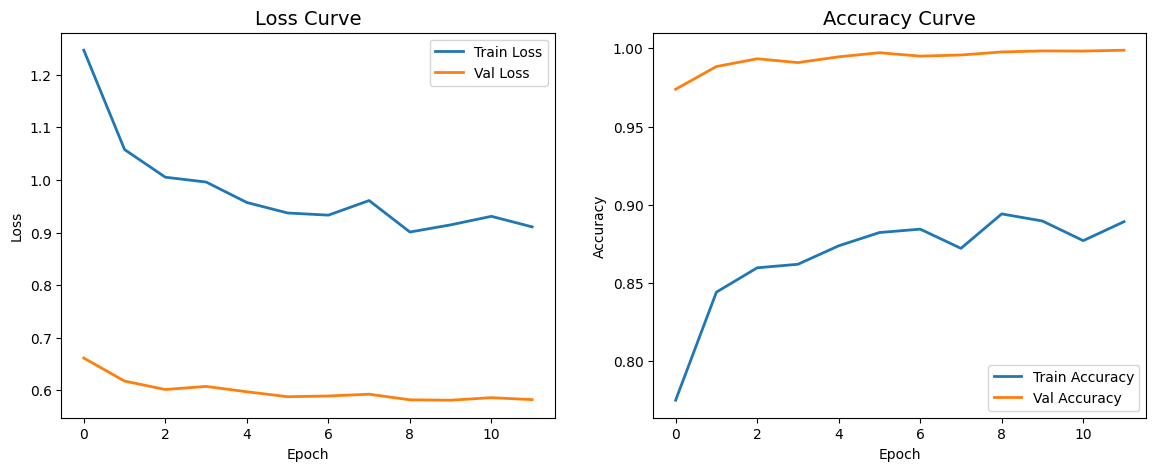

In [16]:
# 1. PLOT TRAINING CURVES
plt.figure(figsize=(14,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss", linewidth=2)
plt.plot(history["val_loss"], label="Val Loss", linewidth=2)
plt.title("Loss Curve", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy", linewidth=2)
plt.plot(history["val_acc"], label="Val Accuracy", linewidth=2)
plt.title("Accuracy Curve", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


Loaded pretrained weights for efficientnet-b0


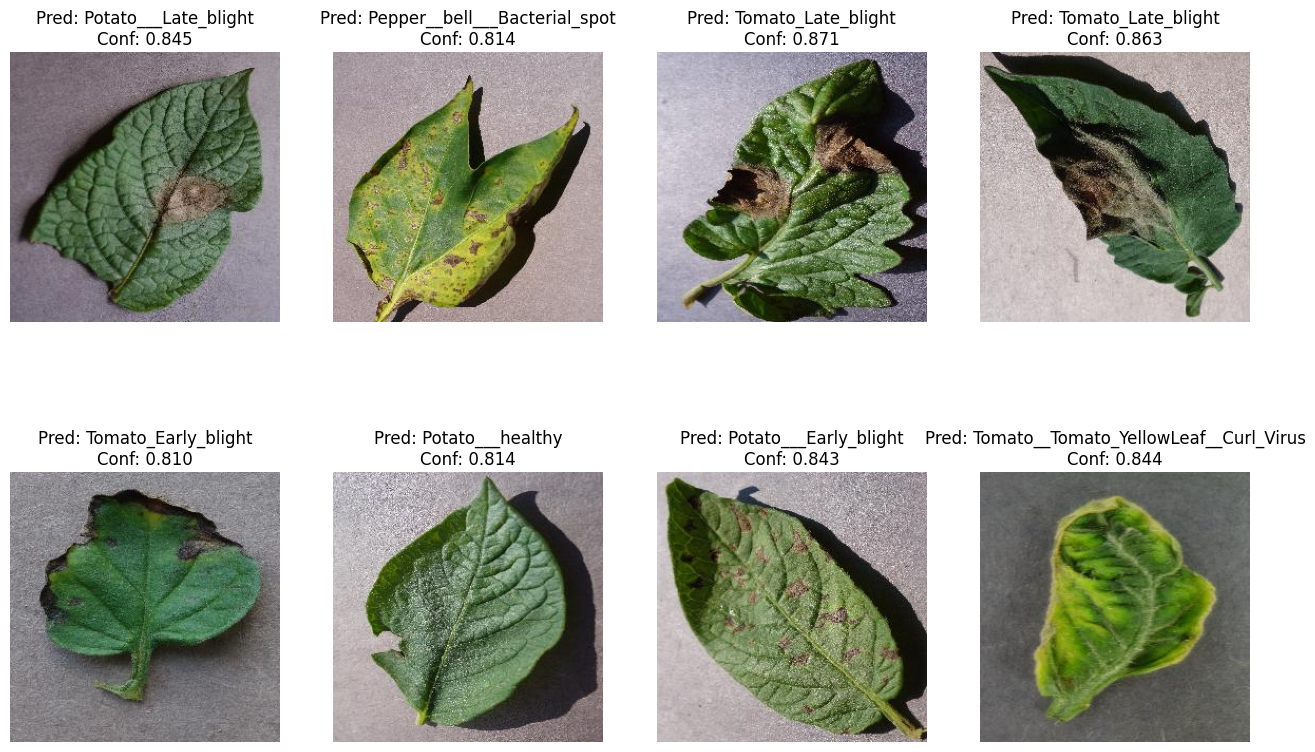

In [17]:
import random

def show_predictions(model_path=MODEL_PATH, num_images=8):
    ckpt = torch.load(model_path, map_location=DEVICE)
    class_names = ckpt["classes"]

    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(class_names))
    model.load_state_dict(ckpt["model"])
    model.to(DEVICE)
    model.eval()

    plt.figure(figsize=(16,10))

    for i in range(num_images):
        img_path, label = random.choice(val_dataset.samples)
        img = Image.open(img_path).convert("RGB")

        x = val_tf(img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            logits = model(x)
            prob = F.softmax(logits, dim=1)
            idx = prob.argmax().item()
            confidence = float(prob[0][idx])

        plt.subplot(2, num_images//2, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {class_names[idx]}\nConf: {confidence:.3f}")

    plt.show()

# Run it:
show_predictions()


In [19]:
!pip install seaborn



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded pretrained weights for efficientnet-b0


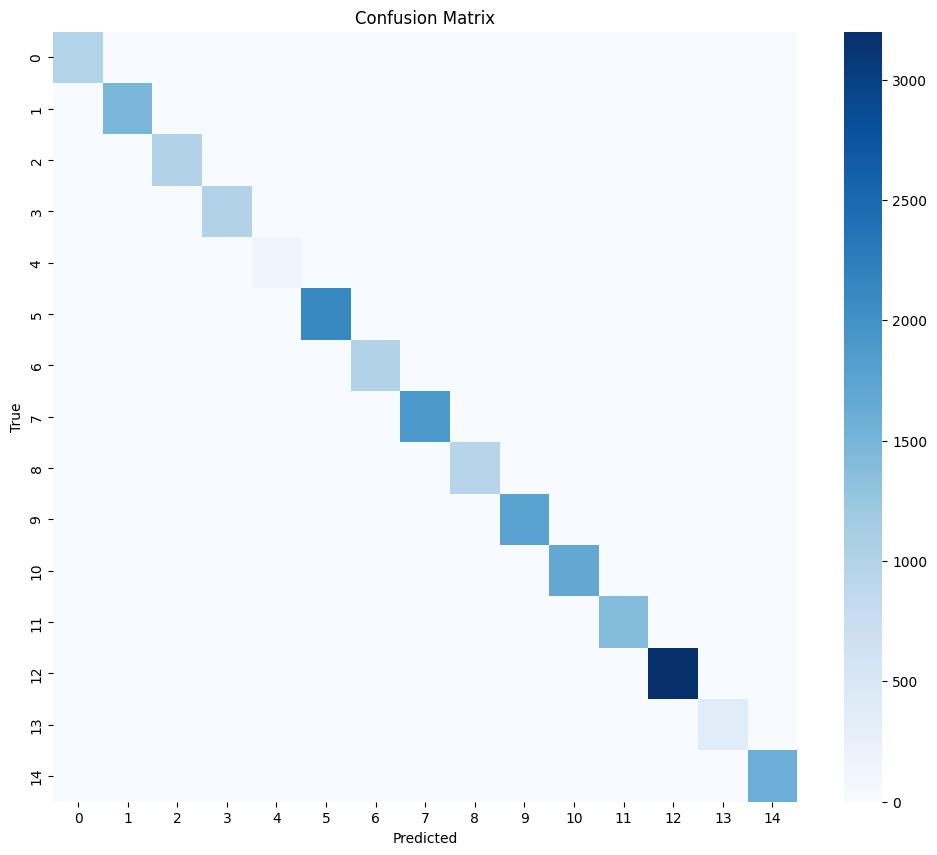


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       997
                     Pepper__bell___healthy       1.00      1.00      1.00      1478
                      Potato___Early_blight       1.00      1.00      1.00      1000
                       Potato___Late_blight       1.00      1.00      1.00      1000
                           Potato___healthy       1.00      1.00      1.00       152
                      Tomato_Bacterial_spot       1.00      1.00      1.00      2127
                        Tomato_Early_blight       1.00      1.00      1.00      1000
                         Tomato_Late_blight       1.00      1.00      1.00      1909
                           Tomato_Leaf_Mold       1.00      1.00      1.00       952
                  Tomato_Septoria_leaf_spot       1.00      1.00      1.00      1771
Tomato_Spider_mites_Two_spotted_spider_m

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get all predictions
y_true = []
y_pred = []

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(class_names))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE)["model"])
model.to(DEVICE)
model.eval()

with torch.no_grad():
    for X, y in val_loader:
        X = X.to(DEVICE)
        logits = model(X)
        preds = logits.argmax(1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Per-class accuracy
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
